In [1]:
import pandas as pd
import random
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
import time

#Specialized packages
import nltk
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora, models
from scipy.special import gammaln
import re

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/edarin/.virtualenvs/ensae/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Latent Dirichlet Allocation applied to real data

In [253]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Data fetching and preprocessing

### Building sample dataset

We are considering a collection of English news articles about the case relating to allegations of sexual assault against the former IMF director Dominique Strauss-Kahn (May 2011). It was obtained thanks to a Web Search with keywords and provided generosyly by Aurélien Lauf, Leila Khouas and Mohamed Dermouche on the UCL Machine Learning Repository at : https://archive.ics.uci.edu/ml/datasets/NYSK

In [4]:
#get raw data
import xml.etree.ElementTree as ET
tree = ET.parse('../dataset/nysk.xml')
root = tree.getroot()
root1 = root.getchildren()[150].getchildren()

texts=[]
for document in root.iter('document'):
        text = document.find('text').text
        texts += [text]


In [235]:
#Example of text
texts[1]

'Associated Press - May 19, 2011 2:45 PM ET NEW YORK (AP) - Dominique Strauss-Kahn is appearing before a judge in New York City in a bid for freedom while he awaits trial on a sexual abuse charge. The former head of the International Monetary Fund arrived in the courtroom Thursday afternoon wearing a gray suit. He turned to give a quick smile to supporters in the gallery that included a daughter and his wife, Anne Sinclair. Sinclair entered the courthouse without speaking to the hundreds of journalists gathered outside. Strauss-Kahn has been behind bars since Saturday after he was accused of trying to rape a maid at a Manhattan hotel. He has offered to post $1 million bail, remain under house arrest in New York and wear a monitoring device. Strauss-Kahn resigned his post at the IMF Wednesday night. Copyright 2011 The Associated Press. All rights reserved. This material may not be published, broadcast, rewritten or redistributed. '

We can see from this example that the textual data are not very cleaned: title and paratext might ne included in the sample.

We will consider for the implementation 250 articles out of the 10421 for computational cost. Please note that the code itself is scalable up to an higher limit.

In [180]:
# Sample texts
print(len(texts))
shuffle(texts)
texts_test = texts[:250]
print(len(texts_test))

10421
250


### Textual data preprocessing
We have first to make readable the corpus of text. Several steps are needed for that purpose among them: stemming, tokenization and dropping of stop words.

In [181]:
from nltk.tokenize import MWETokenizer
from nltk.stem.snowball import SnowballStemmer

#### define stop words
We came out with this list of words to delete while looking at the distribution of words and those that are meaning less in our context

In [182]:
my_stop_words = nltk.corpus.stopwords.words('english')

# Add my stopwords
my_stop_words = my_stop_words + ["n't", "'s", "wednesday", "year", 
                                 "ve", "said", "a", "would", "may", "say", "saturday",
                                "thursday", "select", "one", "part"]

#### words to understand as one token
The idea now is to define the unit of analysis, the *token* in natural language processing field. For some standard expression in our context we define as token a succession of word thanks to the function `MWETokenizer` of the package `nltk`.

In [183]:
tokenizer = MWETokenizer([("world", "trade", "organisation"), ('dominique', 'strauss-kahn'), 
                          ("international", "monetary", "fund"), ('new', 'york'), ("wall", "street")]) 

In [184]:
stemmer = SnowballStemmer("english")


In [185]:
texts_tok = []
for text in texts_test:
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    tokens = tokenizer.tokenize(tokens)
    filtered_tokens = []
    for token in tokens:
            if token not in my_stop_words:
                if re.search('[a-zA-Z]', token):
                    stemmed_token = stemmer.stem(token)
                    filtered_tokens.append(stemmed_token)
            
    texts_tok += [filtered_tokens]
    

#### an high-dimensionnal vocabulary
One problem of text analysis is the high number of unique words that are to be found in the corpus and its corollary the sparsity. We want first to give an overview of this issue and then to answer to it thanks to the method implemented in `TfidfVectorizer` of `scikit-learn`

Most frequent words
                        value
strauss-kahn             1056
imf                      1000
new_york                  598
dominique_strauss-kahn    460
french                    419



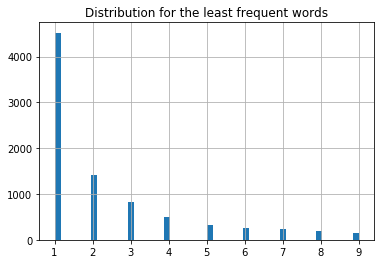

In [228]:
from collections import defaultdict
frequency = defaultdict(int)
for text in texts_tok:
    for token in text:
        frequency[token] += 1


df_freq = pd.DataFrame(frequency, index=['value']).T
print('Most frequent words')
print(df_freq.sort_values(['value'], ascending=False).head())
df_freq[df_freq['value'] <10].hist(['value'], bins=50)
plt.title('Distribution for the least frequent words')
print()

In [187]:
# Extract the most discrimnant tokens 
def tokenStem(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    tokens = tokenizer.tokenize(tokens)
    filtered_tokens = []
    for token in tokens:
            if re.search('[a-zA-Z]', token):
                stemmed_token = stemmer.stem(token)
                filtered_tokens.append(stemmed_token)
            
    return filtered_tokens
  
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words=my_stop_words,
                                 use_idf=True, tokenizer=tokenStem, ngram_range=(1,1))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(texts_test)

terms = tfidf_vectorizer.get_feature_names()

#Build 
texts_red = [[token for token in text if token in terms]  for text in texts_tok]

#### Translate token to index
We will write the algorithm to work on numbers more than on actual words. The idea is thus to translate the full range of words into indices, keeping the translation rule carefully. For that purpose we consider the package `gensim`.

In [190]:
# Building the dictionnary
dictionary = corpora.Dictionary(texts_red)
# Store the translation rule in a pd.DataFrame
dict_df = pd.DataFrame(data=dictionary.token2id, index=['value']).T
dict_df.head()

,value
abus,45
accord,75
accus,46
act,241
ago,0


In [191]:
# Translating our corpus
texts_idx = [dictionary.doc2idx(text) for text in texts_red]
# Example
texts_idx[2]

[56,
 17,
 3,
 56,
 137,
 98,
 142,
 24,
 180,
 38,
 30,
 51,
 147,
 158,
 36,
 3,
 54,
 59,
 175,
 111,
 144,
 126,
 120,
 60,
 54,
 38,
 137,
 98,
 56,
 7,
 56,
 17,
 3,
 162,
 123,
 165,
 30,
 89,
 21,
 26,
 62,
 162,
 123,
 7,
 71,
 34,
 59,
 30,
 54,
 169,
 111,
 56,
 17,
 3,
 183,
 56,
 17,
 2,
 142,
 144,
 21,
 89,
 46,
 26,
 36,
 7,
 81,
 59,
 30,
 54,
 111,
 56,
 17,
 3,
 136,
 159,
 112,
 144,
 77,
 36,
 3,
 30,
 54,
 111,
 152,
 89,
 21,
 38,
 175,
 112,
 27,
 136,
 131,
 84,
 140,
 31,
 151,
 163,
 56,
 17,
 3,
 162,
 123,
 30,
 165,
 89,
 21,
 96,
 7,
 71,
 34,
 59,
 30,
 51,
 54,
 169,
 147,
 134,
 54,
 56,
 88,
 56,
 17,
 181,
 125,
 175,
 170,
 140,
 142,
 90,
 56,
 89,
 23,
 141,
 49,
 67,
 168,
 133,
 48,
 33,
 65,
 30,
 112,
 148,
 18,
 132,
 179,
 162,
 123,
 125,
 50,
 162,
 68,
 26,
 56,
 89,
 60,
 94,
 80,
 49,
 7,
 36,
 3,
 54,
 59,
 28,
 106,
 154,
 38,
 67,
 137,
 98,
 21,
 75,
 160,
 105,
 86,
 38,
 97,
 77,
 67,
 116,
 172,
 107,
 1,
 179,
 155,
 56,
 94,
 3

#### Illustration: length diversity of texts in corpus

868 2


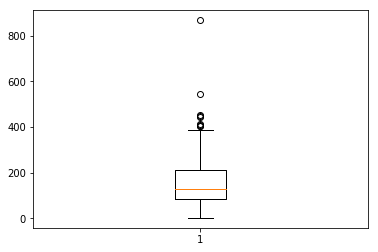

In [230]:
length = []
for text in range(len(texts_idx)):
    length += [len(texts_idx[text])]

plt.figure()
plt.boxplot(length)

print(max(length), min(length))

## Implementation of the Latent Dirichlet Allocation

### The generative model

Let's recall briefly to understand the notation the generative graphical model that is under the LDA. We won't discuss here further.


Given $d \in \{1, \cdots n_{docs}\}$, the document index, $w \in \{1, \cdots, n_{words}\}$ the word index, $ k \in \{1, \cdots, n_{topics}\}$ the topic index, the underlying process modeled by LDA is:

- to generate $\pi_d \sim \mathcal{Dir}(\alpha)$the topics distribution for the document $d$.
- to pick $t_{dw} \sim \mathcal{Mult}(\pi_i)$ the topic $k$ for the word $w$. 
- to generate $\phi_k \sim \mathcal{Dir}(\beta)$ the distribution of words for topic $k$.
- to pick $y_{dw}| t_{dw} \sim \mathcal{Mult}(\phi_k)$ the word $w$ knowing the topic $k$.

The variables to infer in the process is the two unknown latent variable $\pi_d$ and $\phi_k$ what can be done with several techniques as describe in the article's commentary. We want here to implement the Collapsed Gibbs Sampling for its familiarity and the nice explanation written in Griffiths TL, Steyvers M. *Finding scientific topics*. From their demonstration we get that the full conditional distribution is:


$ \Pi(t_{dw}) \equiv P(t_{dw}=j | t_{-d}, w) \propto \frac{n_{-d,j}^{w}  + \beta}{n_{-d,j} + W\beta}\frac{n_{-d,j}^d + \alpha}{n_{-d}^d + T\alpha}$

### Definition of hyperparameters

In [194]:
n_docs = len(texts_idx) # Number of documents in corpus
n_words = len(dict_df) # Number of words in full corpus
n_topics =5 # Number of topics we want to find
n_iter =20
alpha = 0.1
beta =0.1

### Initialisation

In [195]:
def initialisation(n_docs,n_topics,n_words,texts_idx):
    
    doc_topic = np.zeros((n_docs, n_topics)) # number of words per topic for each doc
    word_topic = np.zeros((n_topics, n_words)) # count of each word for each topic
    doc = np.zeros(n_docs) # number of words for each doc/length of each doc
    topic = np.zeros(n_topics) # number of words for each topic
    topics_peridx = {} # topic assigned for each word for each document 
    
    for d in range(n_docs):
        idx =0
        for w in texts_idx[d]:
            # generate random data for the first step
            t=np.random.randint(n_topics)
            doc_topic[d, t] +=1 #
            doc[d] +=1
            word_topic[t,w] +=1
            topic[t] +=1
            topics_peridx[(d,idx)] = t
            idx +=1
            
    output = [doc_topic, doc, word_topic, topic, topics_peridx]
    return output

new = initialisation(n_docs,n_topics,n_words,texts_idx)
doc_topic = new[0]
doc = new[1]
word_topic = new[2]
topic = new[3]
topics_peridx =new[4]

#### Understanding the object : `word_topic`
This matrix gather the count of each kind of words per topic. It described the corpus that defines the topic.

Ex: the number of *word_0* in topic *t*.

In [196]:
print(word_topic.shape) # n_topics*n_words (number of topics * number of words in final dictionary)
print(word_topic)


(5, 256)
[[18. 50. 43. ... 21.  0.  1.]
 [18. 53. 58. ... 12.  0.  0.]
 [13. 53. 57. ... 17.  1.  1.]
 [22. 44. 56. ... 20.  0.  0.]
 [21. 60. 65. ... 15.  0.  0.]]


We can check that the amount of *word_0* in the full corpus is dispatched between each topic. 

**NB**:It illustrates one interesting feature in Latent Dirichlet Allocation that allows one word to be in several topic thus having different meaning relatively to the context.

In [197]:
# Find the word corresponding to the index 0
value0 = dict_df[dict_df.value==0].index[0]
print(value0)

ago


In [198]:
# Look for its frequency inside the final vocabulary (of texts_red)
freq_red = defaultdict(int)
for text in texts_red:
    for token in text:
        freq_red[token] += 1

print('Number of occurences in full corpus:',freq_red[value0])
print('Dispatched word_0 to each topic:',freq_red[value0] == sum(word_topic[:,0]) )

Number of occurences in full corpus: 92
Dispatched word_0 to each topic: True


#### Understanding the object `doc_topic`
This matrix represents the count of words for each document *d* that belongs to each topic *t*. It describes which topic is present in document *d* and with which relative intensity.

Example: document *d* has 13 words that are classified to belong to *t*.

**NB**: It illustrates the fact that one document can entail/be generated by several topics.


In [199]:
print(doc_topic[0:10]) 
print()
print('Matrix shape',doc_topic.shape) # n_docs*n_topics

[[ 19.  11.  13.   9.  14.]
 [ 13.   7.  11.   5.  10.]
 [ 87.  73.  79. 110.  95.]
 [ 12.  11.   8.  11.   9.]
 [ 41.  43.  46.  33.  49.]
 [ 35.  28.  28.  28.  33.]
 [ 51.  66.  49.  57.  55.]
 [ 28.  39.  32.  35.  43.]
 [ 46.  38.  39.  38.  37.]
 [ 44.  45.  40.  43.  41.]]

Matrix shape (250, 5)


We can check that the number of words classified matches the number of word in the document

In [200]:
print('Number of words in document_0:', len(texts_idx[0]))
print('Equals to sum of words in each topic for document_0:',sum(doc_topic[0])==len(texts_idx[0]))

Number of words in document_0: 66
Equals to sum of words in each topic for document_0: True


### Algorithm

In [201]:
def pi(d,w, alpha, beta):
    '''
    Compute p(t|w, -t): 
    the full conditional distribution of topic t given the word w
    '''
    left = (word_topic[:,w] + beta) / (topic + beta*n_words)
    right = (doc_topic[d,:] + alpha) / (doc[d] + alpha*n_topics)
    p_t = left*right # is equivalent
    p_t /= (np.sum(p_t)) # normalization to get a probability
    return(p_t)

In [202]:
start_time = time.time()
for iteration in range(n_iter):
    print('iteration:',iteration)
    for d in range(n_docs):
        idx =0
        for w in texts_idx[d]:        
            t = topics_peridx[(d,idx)]
            
            # withdraw the current assignment of t
            doc_topic[d, t] -=1 
            doc[d] -=1
            word_topic[t,w] -=1 
            topic[t] -=1
            
            # compute the conditional distribution
            p_t = pi(d,w,alpha, beta)
            
            # choose the topic for word w
            t = np.random.multinomial(1,p_t)
            t= t.argmax()

            doc_topic[d, t] +=1 
            doc[d] +=1
            word_topic[t,w] +=1
            topic[t] +=1
            topics_peridx[(d,idx)] = t

            idx +=1
print("--- %s seconds ---" % (time.time() - start_time))

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
--- 62.25557208061218 seconds ---


### The result
We chek the relative imabalance of number of words between the topic

In [203]:
# Relative number of words per topic
pd.DataFrame(topic/sum(topic)*100).T

,0,1,2,3,4
0,19.609547,25.039608,27.717586,13.305565,14.327695


In [204]:
# Distribution of words per topic
word_topic_df = pd.DataFrame(word_topic)
word_topic_df.columns = dict_df.sort_values(['value']).index
word_topic_df

,ago,also,arrest,assault,attempt,back,bank,charg,come,consid,...,work,much,relat,chang,member,recent,well,polici,veri,ani
0,39.0,122.0,20.0,86.0,57.0,29.0,4.0,86.0,42.0,32.0,...,81.0,33.0,21.0,13.0,31.0,0.0,61.0,25.0,0.0,0.0
1,0.0,77.0,0.0,15.0,3.0,41.0,141.0,78.0,39.0,36.0,...,1.0,32.0,0.0,14.0,28.0,17.0,17.0,0.0,0.0,0.0
2,2.0,2.0,189.0,154.0,43.0,31.0,0.0,208.0,1.0,0.0,...,0.0,0.0,0.0,0.0,16.0,5.0,0.0,0.0,1.0,0.0
3,42.0,3.0,15.0,6.0,0.0,43.0,56.0,0.0,28.0,19.0,...,26.0,4.0,45.0,31.0,10.0,47.0,26.0,60.0,0.0,0.0
4,9.0,56.0,55.0,0.0,16.0,0.0,0.0,0.0,14.0,0.0,...,30.0,14.0,11.0,16.0,33.0,19.0,5.0,0.0,0.0,2.0


In [205]:
# Estimation of pi : P(w|t)
word_topic_df / word_topic_df.sum(axis=0)

,ago,also,arrest,assault,attempt,back,bank,charg,come,consid,...,work,much,relat,chang,member,recent,well,polici,veri,ani
0,0.423913,0.469231,0.071685,0.329502,0.478992,0.201389,0.019900,0.231183,0.338710,0.367816,...,0.586957,0.397590,0.272727,0.175676,0.262712,0.000000,0.559633,0.294118,0.0,0.0
1,0.000000,0.296154,0.000000,0.057471,0.025210,0.284722,0.701493,0.209677,0.314516,0.413793,...,0.007246,0.385542,0.000000,0.189189,0.237288,0.193182,0.155963,0.000000,0.0,0.0
2,0.021739,0.007692,0.677419,0.590038,0.361345,0.215278,0.000000,0.559140,0.008065,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.135593,0.056818,0.000000,0.000000,1.0,0.0
3,0.456522,0.011538,0.053763,0.022989,0.000000,0.298611,0.278607,0.000000,0.225806,0.218391,...,0.188406,0.048193,0.584416,0.418919,0.084746,0.534091,0.238532,0.705882,0.0,0.0
4,0.097826,0.215385,0.197133,0.000000,0.134454,0.000000,0.000000,0.000000,0.112903,0.000000,...,0.217391,0.168675,0.142857,0.216216,0.279661,0.215909,0.045872,0.000000,0.0,1.0


#### definition of topics with their related words

In [208]:
for t in range(n_topics):
    topic_ = word_topic_df.iloc[t]
    print('topic', t)
    print(topic_[topic_ >50].index)

topic 0
Index(['also', 'assault', 'attempt', 'charg', 'last', 'make', 'need',
       'new_york', 'polit', 'rape', 'right', 'sexual', 'strauss-kahn', 'two',
       'us', 'week', 'maid', 'support', 'accord', 'alleg', 'ask', 'author',
       'case', 'franc', 'french', 'go', 'know', 'law', 'like', 'man', 'mani',
       'person', 'power', 'presidenti', 'public', 'report', 'sarkozi', 'sex',
       'think', 'time', 'use', 'victim', 'way', 'woman', 'peopl', 'problem',
       'take', 'three', 'women', 'american', 'even', 'act', 'work', 'well'],
      dtype='object')
topic 1
Index(['also', 'bank', 'charg', 'econom', 'european', 'financ', 'head',
       'international_monetary_fund', 'minist', 'new_york', 'next',
       'strauss-kahn', 'former', 'imf', 'resign', 'sinc', 'support', 'board',
       'candid', 'chief', 'could', 'countri', 'director', 'economi', 'europ',
       'face', 'first', 'franc', 'french', 'friday', 'intern', 'manag', 'name',
       'nation', 'new', 'presid', 'think', 'time', '

A complete analysis of the result is out of our goal since we haven't thought long enough to our data that were a little bit unclean due to the fetching method (sometimes other info that were we guess around the article in the website page are in fact integrated to the text). Still we can interpret the topic 4 to be related to international matter, the topic 3 to economics, topic 2 to juridical matter, topic 1 the global picture in terms of network and topic 0 to the act itself.

## Playing with the features

Next idea is to understand the impact when we vary some hyperparameters or parameters we considered as constant. For that purpose we decided to compare the performance along two axis:
- how well the estimated loglikelihood represent the data
- what is the running time of the transformed algorithm

For that we should recall the form of the likelihood and apply to it the logarithm of the multinomial beta function. We get this idea from Blondel (http://mblondel.org/journal/2010/08/21/latent-dirichlet-allocation-in-python/).

#### Definitions

In [209]:
def log_multi_beta(alpha, K=None):
    """
    Logarithm of the multinomial beta function.
    """
    if K is None:
        # alpha is assumed to be a vector
        return np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))
    else:
        # alpha is assumed to be a scalar
        return K * gammaln(alpha) - gammaln(K*alpha)
    

In [210]:
def loglikelihood():
    """
    Compute the likelihood that the model generated the data.
    """

    loglik = 0

    for t in range(n_topics):
        loglik += log_multi_beta(word_topic[t,:]+beta)
        loglik -= log_multi_beta(beta, n_words)

    for d in range(n_docs):
        loglik += log_multi_beta(doc_topic[d,:]+alpha)
        loglik -= log_multi_beta(alpha, n_topics)
    
    return loglik

In [211]:
def LDA(n_iter,alpha,beta, verbose =False):
    logliks = []
    for iteration in range(n_iter):
        for d in range(n_docs):
            idx =0
            for w in texts_idx[d]:        
                t = topics_peridx[(d,idx)]

                # withdraw the current assignment of t
                doc_topic[d, t] -=1 
                doc[d] -=1
                word_topic[t,w] -=1 
                topic[t] -=1

                p_t = pi(d,w, alpha, beta)

                t = np.random.multinomial(1,p_t)
                t= t.argmax()

                doc_topic[d, t] +=1 
                doc[d] +=1
                word_topic[t,w] +=1
                topic[t] +=1
                topics_peridx[(d,idx)] = t

                idx +=1
        
        if (iteration % 5==0): 
            print('iteration:',iteration)
        if (verbose==True):
            loglik = loglikelihood()
            print("loglikelihood",round(loglik))
            logliks += [loglik]
    if verbose == False:   
        logliks = loglikelihood()
        print("loglikelihood",round(logliks))
    return(logliks)


### Study of time convergence
We want to know how many iterations are needed to stabilize the loglikelihood, the idea being that one iteration is already time-consuming so that we want to minimize the number of iterations.

In [212]:
new = initialisation(n_docs,n_topics,n_words,texts_idx)
doc_topic = new[0]
doc = new[1]
word_topic = new[2]
topic = new[3]
topics_peridx =new[4]

In [213]:
n_iter = 70
%time convergenceLDA = LDA(n_iter, alpha,beta, verbose = True)

iteration: 0
loglikelihood -275573.0
loglikelihood -271495.0
loglikelihood -267059.0
loglikelihood -261684.0
loglikelihood -254881.0
iteration: 5
loglikelihood -247097.0
loglikelihood -240712.0
loglikelihood -236350.0
loglikelihood -233533.0
loglikelihood -231356.0
iteration: 10
loglikelihood -229701.0
loglikelihood -228448.0
loglikelihood -227607.0
loglikelihood -227360.0
loglikelihood -226397.0
iteration: 15
loglikelihood -226232.0
loglikelihood -226032.0
loglikelihood -226074.0
loglikelihood -226179.0
loglikelihood -225769.0
iteration: 20
loglikelihood -225305.0
loglikelihood -225121.0
loglikelihood -224865.0
loglikelihood -224980.0
loglikelihood -225057.0
iteration: 25
loglikelihood -224675.0
loglikelihood -224531.0
loglikelihood -224244.0
loglikelihood -224057.0
loglikelihood -223778.0
iteration: 30
loglikelihood -223911.0
loglikelihood -223802.0
loglikelihood -223575.0
loglikelihood -223571.0
loglikelihood -223915.0
iteration: 35
loglikelihood -223925.0
loglikelihood -223959.0
lo

(-290000, -210000)

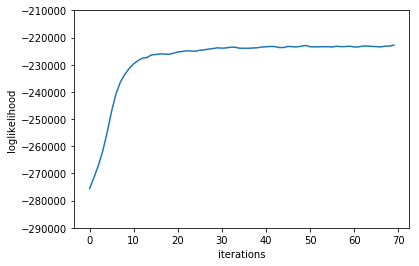

In [249]:
x = range(n_iter)
fig = plt.figure()
plt.plot(x,convergenceLDA)
plt.ylabel('loglikelihood')
plt.xlabel('iterations')
plt.ylim(-290000, -210000)


### Influence of Dirichlet parameters

$\alpha$ and $\beta$ are the parameters for the two Dirichlet priors. They are called the concentration parameter, since in our symmetric distribution case, a high value means an higher degree of mixture of the input. More precisely the higher the $\alpha$, the more likely each document contains a mixture of most of the topics, and not any single topic specifically.  Likewise, a high $\beta$-value means that each topic is likely to contain a mixture of most of the words, and not any word specifically, while a low value means that a topic may contain a mixture of just a few of the words.

In [223]:
#Study on alpha
lik_alpha = []
iter_alpha = np.linspace(0.1, 2.0, num=10).tolist()
for alpha in iter_alpha:
    print('alpha:',alpha)
    new = initialisation(n_docs,n_topics,n_words,texts_idx)
    doc_topic = new[0]
    doc = new[1]
    word_topic = new[2]
    topic = new[3]
    topics_peridx =new[4]
    lik = LDA(20, alpha, beta)
    lik_alpha += [lik]
    

alpha: 0.1
iteration: 0
iteration: 5
iteration: 10
iteration: 15
loglikelihood -226366.0
alpha: 0.3111111111111111
iteration: 0
iteration: 5
iteration: 10
iteration: 15
loglikelihood -227011.0
alpha: 0.5222222222222223
iteration: 0
iteration: 5
iteration: 10
iteration: 15
loglikelihood -227217.0
alpha: 0.7333333333333333
iteration: 0
iteration: 5
iteration: 10
iteration: 15
loglikelihood -228136.0
alpha: 0.9444444444444444
iteration: 0
iteration: 5
iteration: 10
iteration: 15
loglikelihood -226450.0
alpha: 1.1555555555555557
iteration: 0
iteration: 5
iteration: 10
iteration: 15
loglikelihood -226919.0
alpha: 1.3666666666666667
iteration: 0
iteration: 5
iteration: 10
iteration: 15
loglikelihood -228670.0
alpha: 1.577777777777778
iteration: 0
iteration: 5
iteration: 10
iteration: 15
loglikelihood -228307.0
alpha: 1.788888888888889
iteration: 0
iteration: 5
iteration: 10
iteration: 15
loglikelihood -226969.0
alpha: 2.0
iteration: 0
iteration: 5
iteration: 10
iteration: 15
loglikelihood -2

(-290000, -210000)

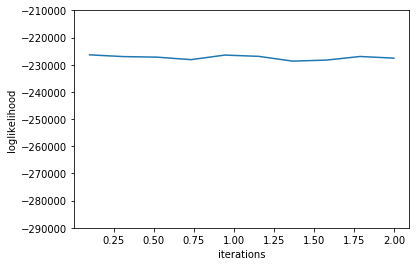

In [250]:
fig = plt.figure()
plt.plot(iter_alpha,lik_alpha)
plt.ylabel('loglikelihood')
plt.xlabel('iterations')
plt.ylim(-290000, -210000)

In [146]:
alpha=0.1
lik_beta = []
iter_beta = np.linspace(0.1, 2.0, num=10).tolist()
for beta in iter_beta:
    print('beta:',beta)
    new = initialisation(n_docs,n_topics,n_words,texts_idx)
    doc_topic = new[0]
    doc = new[1]
    word_topic = new[2]
    topic = new[3]
    topics_peridx =new[4]
    lik = LDA(20, alpha, beta)
    lik_beta += [lik]

beta: 0.1
iteration: 0
iteration: 5
iteration: 10
iteration: 15
loglikelihood -62853.0
beta: 0.3111111111111111
iteration: 0
iteration: 5
iteration: 10
iteration: 15
loglikelihood -62933.0
beta: 0.5222222222222223
iteration: 0
iteration: 5
iteration: 10
iteration: 15
loglikelihood -63261.0
beta: 0.7333333333333333
iteration: 0
iteration: 5
iteration: 10
iteration: 15
loglikelihood -62325.0
beta: 0.9444444444444444
iteration: 0
iteration: 5
iteration: 10
iteration: 15
loglikelihood -62446.0
beta: 1.1555555555555557
iteration: 0
iteration: 5
iteration: 10
iteration: 15
loglikelihood -62404.0
beta: 1.3666666666666667
iteration: 0
iteration: 5
iteration: 10
iteration: 15
loglikelihood -62943.0
beta: 1.577777777777778
iteration: 0
iteration: 5
iteration: 10
iteration: 15
loglikelihood -63271.0
beta: 1.788888888888889
iteration: 0
iteration: 5
iteration: 10
iteration: 15
loglikelihood -62262.0
beta: 2.0
iteration: 0
iteration: 5
iteration: 10
iteration: 15
loglikelihood -62987.0


-63270.97658712652 -62261.86684288377


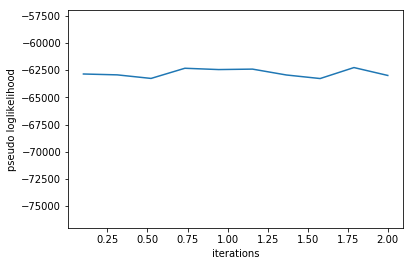

In [150]:
fig = plt.figure()

plt.plot(iter_beta,lik_beta)
plt.ylabel('pseudo loglikelihood')
plt.xlabel('iterations')
plt.ylim(-77000, -57000)
print(min(lik_beta), max(lik_beta))

### Influence of the number of topics

In [245]:
alpha=0.1
beta =0.75
iter_topics = range(2,6)
lik_topics = []
for n_topics in iter_topics:

    print('n_topics:',n_topics)
    new = initialisation(n_docs,n_topics,n_words,texts_idx)
    doc_topic = new[0]
    doc = new[1]
    word_topic = new[2]
    topic = new[3]
    topics_peridx =new[4]
    lik = LDA(20, alpha, beta)
    lik_topics += [lik]

n_topics: 2
iteration: 0
iteration: 5
iteration: 10
iteration: 15
loglikelihood -215986.0
n_topics: 3
iteration: 0
iteration: 5
iteration: 10
iteration: 15
loglikelihood -219695.0
n_topics: 4
iteration: 0
iteration: 5
iteration: 10
iteration: 15
loglikelihood -225012.0
n_topics: 5
iteration: 0
iteration: 5
iteration: 10
iteration: 15
loglikelihood -225256.0


-225255.9112330968 -215985.65539477122


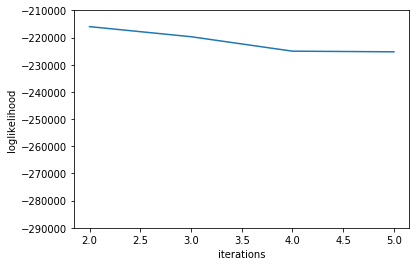

In [251]:
fig = plt.figure()

plt.plot(iter_topics,lik_topics)
plt.ylabel('loglikelihood')
plt.xlabel('iterations')
plt.ylim(-290000, -210000)
print(min(lik_topics), max(lik_topics))

## Conclusion
We have decided to study the collapsed gibbs sampling implementation of the Latent Dirichlet Allocation because of its similarities with algorithms seen in course. An idea would have been to compare our result with other implementation but we thought that it might make no sense since the running time of our implementation and the low capacity of the computer we've done the study is such that this script will experiences difficulties to concurr with alternatives -especially the one using C language (cf. https://github.com/davidandrzej/cvbLDA for a direct implementation of the methodology of the article).

A remark to be done is the really bad likelihood. This result is multiply when considering larger corpus (cf previous experiment where n_docs=50 and loglikelihood = -61950, it can be seen also in the Experimental notebook that we joined)

Furthermore added to the quite slow computation time we can see that it performs better with lower number of topics. Even if it's understandable since the difficulty to partition assignement probabilities in several group increases with the number of group, it's a pity for real data where we want to clusterize in several groups.
